# Print the results


In [2]:
%matplotlib inline

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation

### Configuration

In [4]:
from my_config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = '00'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

In [5]:
config_vars

{'root_directory': 'FISH/',
 'max_training_images': 0,
 'create_split_files': True,
 'training_fraction': 0.8,
 'validation_fraction': 0.1,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'FISH/raw_images/',
 'raw_annotations_dir': 'FISH/raw_annotations/',
 'path_files_training': 'FISH/training.txt',
 'path_files_validation': 'FISH/validation.txt',
 'path_files_test': 'FISH/test.txt',
 'normalized_images_dir': 'FISH/norm_images/',
 'boundary_labels_dir': 'FISH/boundary_labels/',
 'experiment_dir': 'FISH/experiments/00/out/',
 'probmap_out_dir': 'FISH/experiments/00/out/prob/',
 'labels_out_di

In [5]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

### Auxiliary visualization function

In [6]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

### Run the evaluation
Predictions are the ones stored in Step 03 and loaded here for evaluation calculations  
label the ground truth(raw annotations) and compare with the predicted labels

/home/lanbowen23/Instance/unet4nuclei/unet4nuclei/utils/evaluation.py:95: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])


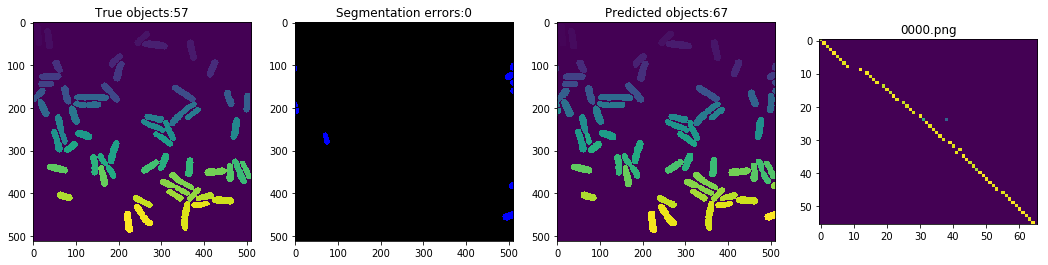

In [7]:
all_images = data_partitions[partition]  # validation

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Precision", "Recall", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
#     prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)

    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

#### show the comparison between norm_image, raw_annot and label_out

In [8]:
import matplotlib as mpl
mpl.rcParams["image.cmap"] # default to viridis

'viridis'

In [9]:
mpl.rcParams["image.cmap"] = 'viridis'

In [40]:
img_name = "0000.png"
pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
pred_label = skimage.io.imread(pred_label_filename)
pred_label = skimage.segmentation.relabel_sequential(pred_label)[0]

inc = lambda x: x if x == 0 else x + 100
inc = np.vectorize(inc)  # this is implemented by for loop
pred_label = inc(pred_label)
print(type(pred_label))
pred_label.min()

<class 'numpy.ndarray'>


0

In [43]:
img_name = "0000.png"
pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
pred_label = skimage.io.imread(pred_label_filename)
pred_label = skimage.segmentation.relabel_sequential(pred_label)[0]
print(pred_label.max(), pred_label.min(), pred_label.shape, type(pred_label))

66 0 (512, 512) <class 'numpy.ndarray'>


In [44]:
def remove(pred_label, cb):
    for i in range(pred_label.shape[0]):
        for j in range(pred_label.shape[1]):
            for c in cb:
                if pred_label[i, j] == c:
                    pred_label[i, j] = 0

In [45]:
def remove_border(pred_label):
    # find the classes of the partial nuclei which located on the border
    # traverse the border
    cb = set()
    for i in range(512):
        if pred_label[i, 0] != 0:
            s.add(pred_label[i, 0])
        if pred_label[0, i] != 0:
            s.add(pred_label[0, i])
        if pred_label[i, 511] != 0:
            s.add(pred_label[i, 511])
        if pred_label[511, i] != 0:
            s.add(pred_label[511, i])
    
    # change these classes to 0 as background
    remove(pred_label, cb)

In [49]:
def compare_2(img_name, pred_label):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
#     pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
#     pred_label = skimage.io.imread(pred_label_filename)

    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
#     pred_label = skimage.morphology.dilation(pred_label, struct)
#     pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    diff, missed, extra = difference(raw_label, pred_label)
        
    # make graph easier to look
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
        
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    fig.suptitle(img_name)
    ax[0].set_title("Original image")
    ax[0].imshow(original_image)
    ax[1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[1].imshow(raw_label)
    ax[2].set_title("Our predicted label: " + str(len(np.unique(pred_label))) + " objects")
    ax[2].imshow(pred_label)
    ax[3].imshow(diff)
    ax[3].set_title("Difference: " + missed + ' missed, ' + extra + ' extra')

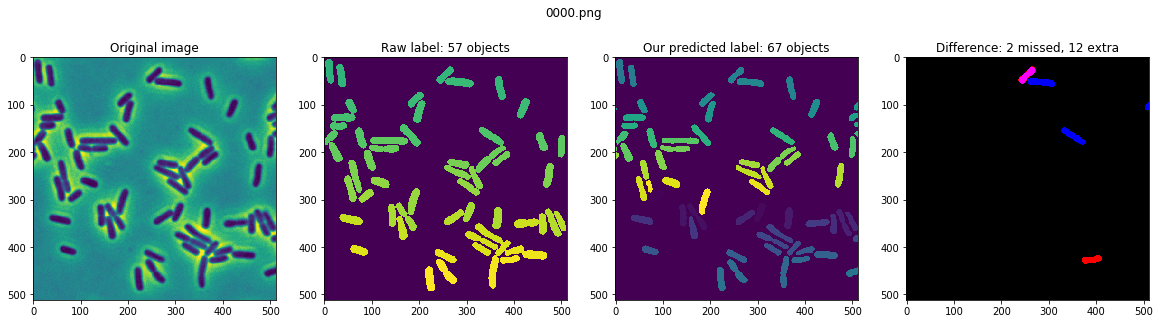

In [50]:
compare_2(img_name, pred_label)

In [36]:
# remove = lambda x: x := 0 if x == 66 else x
def remove(x):
    if x == 66:
        x = 0
remove = np.vectorize(remove) 
pred_label = remove(pred_label)

In [37]:
type(pred_label)
pred_label.min()

TypeError: '<=' not supported between instances of 'NoneType' and 'NoneType'

In [48]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [40]:
def compare(img_name):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
    pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
    pred_label = skimage.io.imread(pred_label_filename)

    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
    pred_label = skimage.morphology.dilation(pred_label, struct)
    pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    diff, missed, extra = difference(raw_label, pred_label)
        
    # make graph easier to look
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
        
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    fig.suptitle(img_name)
    ax[0].set_title("Original image")
    ax[0].imshow(original_image)
    ax[1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[1].imshow(raw_label)
    ax[2].set_title("Our predicted label: " + str(len(np.unique(pred_label))) + " objects")
    ax[2].imshow(pred_label)
    ax[3].imshow(diff)
    ax[3].set_title("Difference: " + missed + ' missed, ' + extra + ' extra')


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

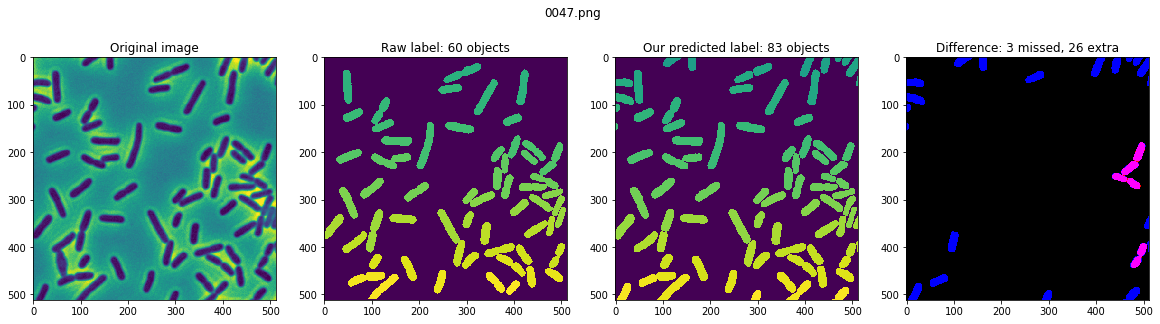

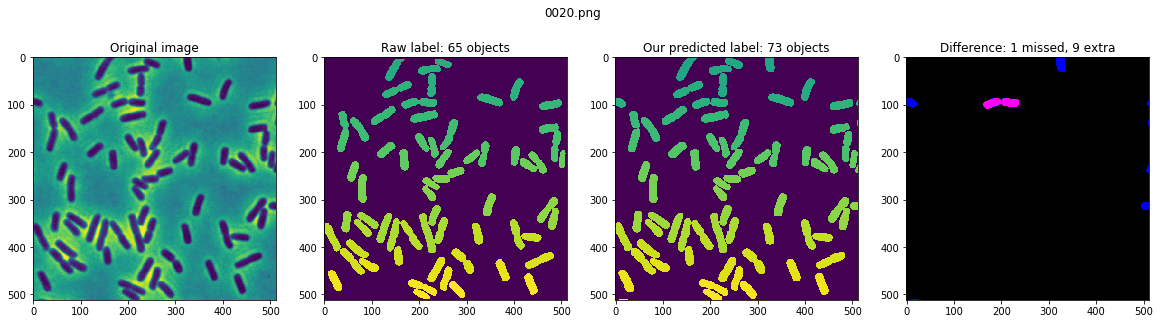

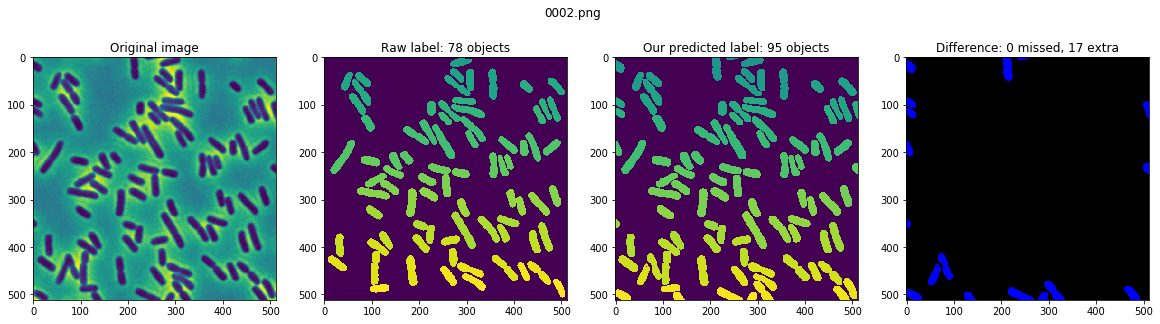

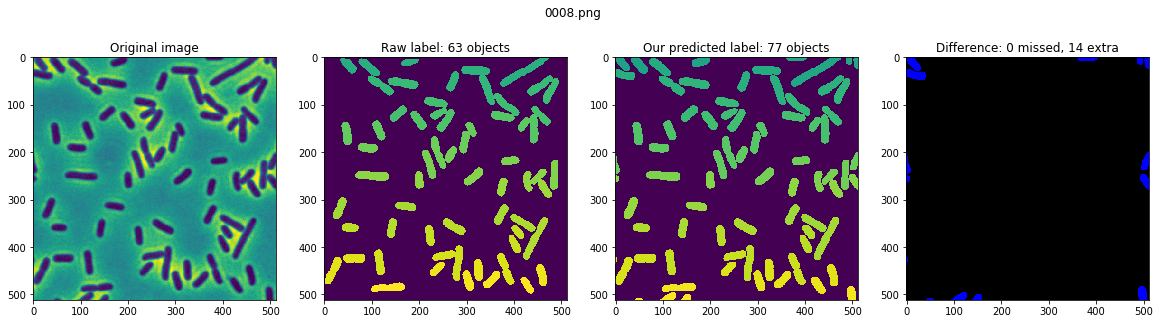

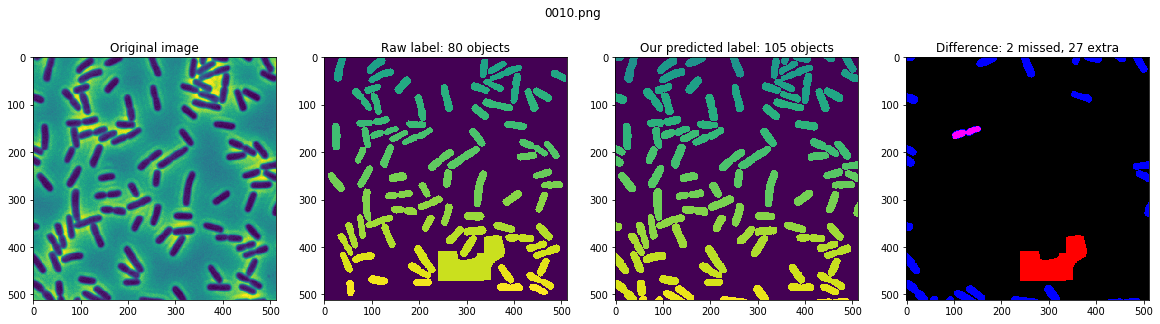

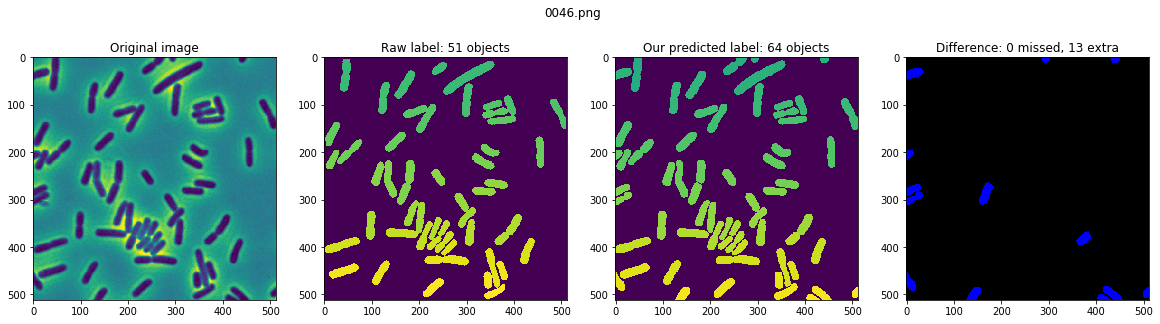

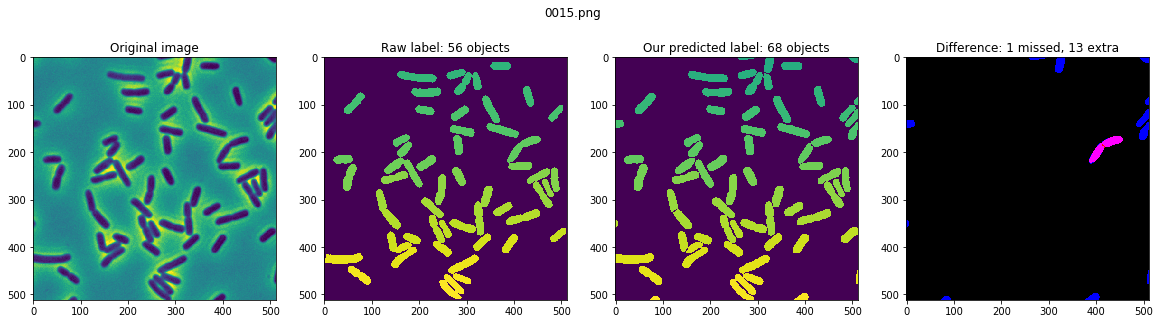

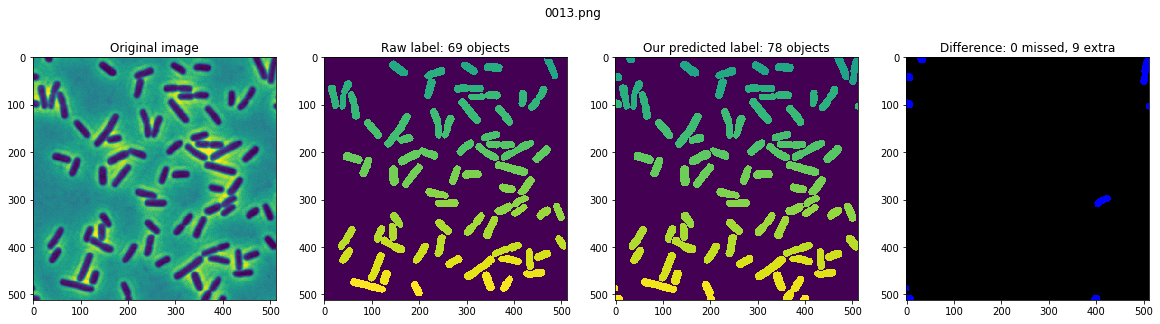

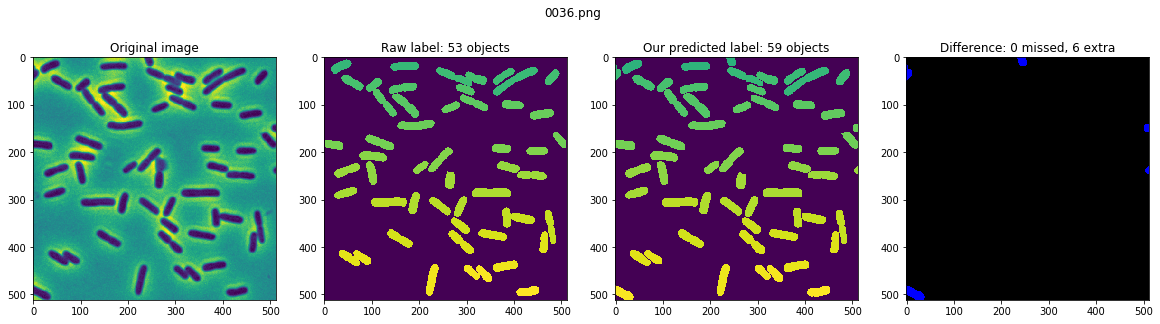

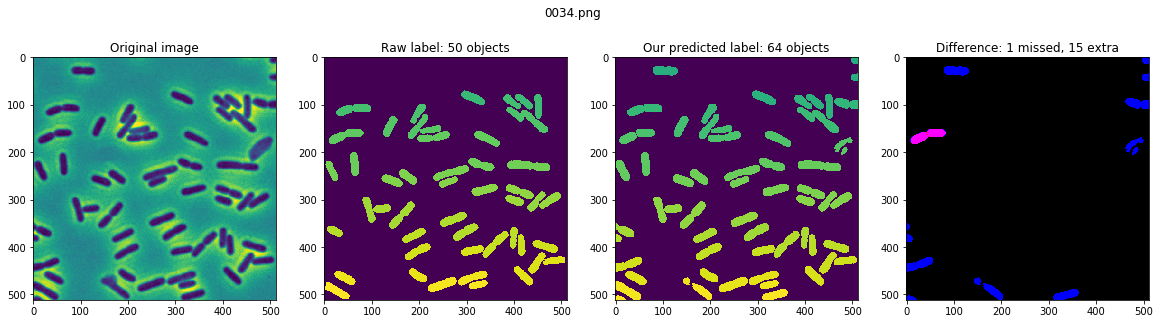

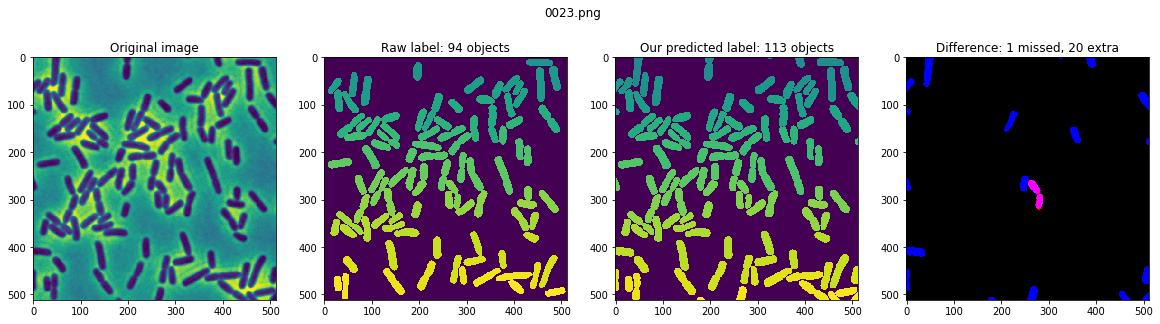

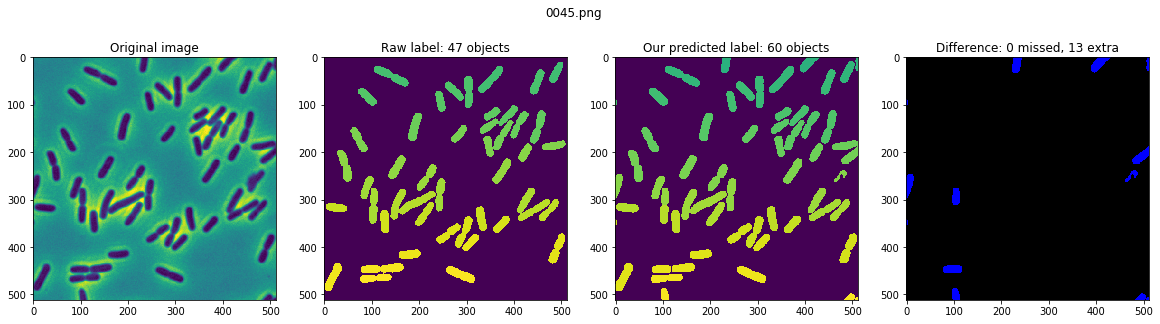

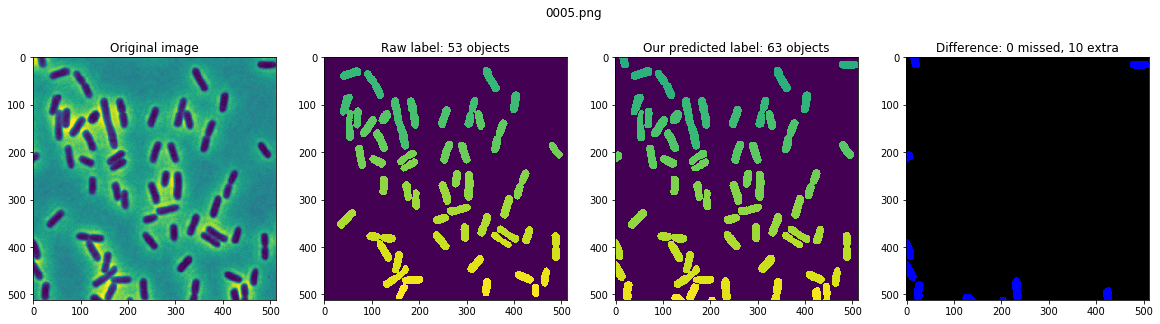

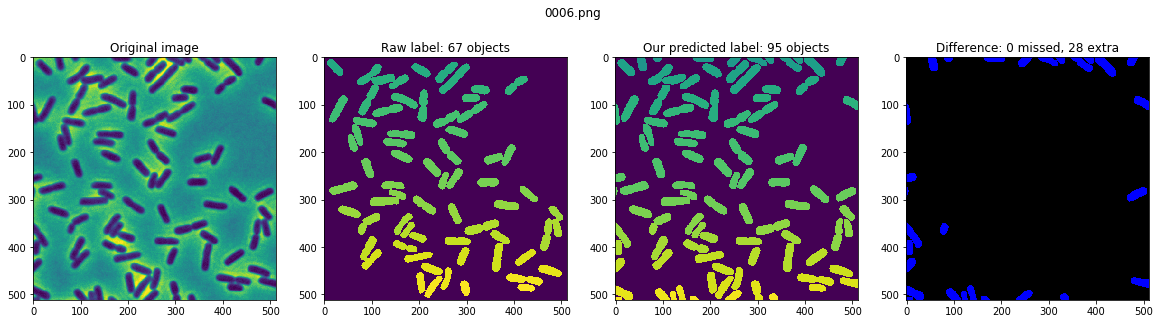

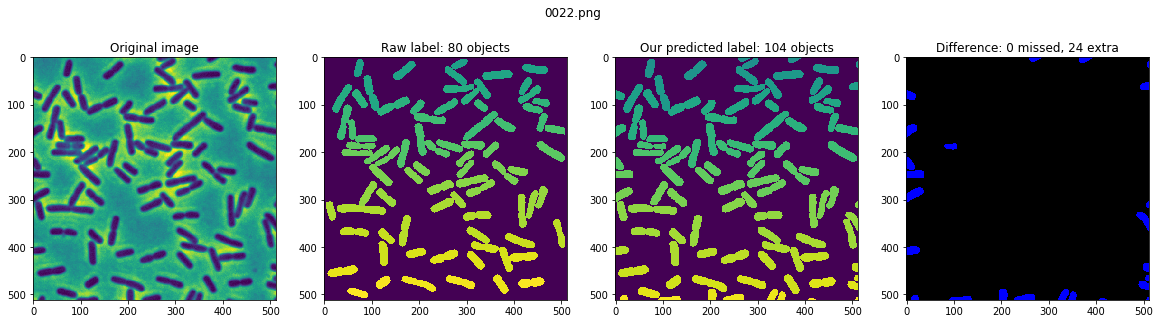

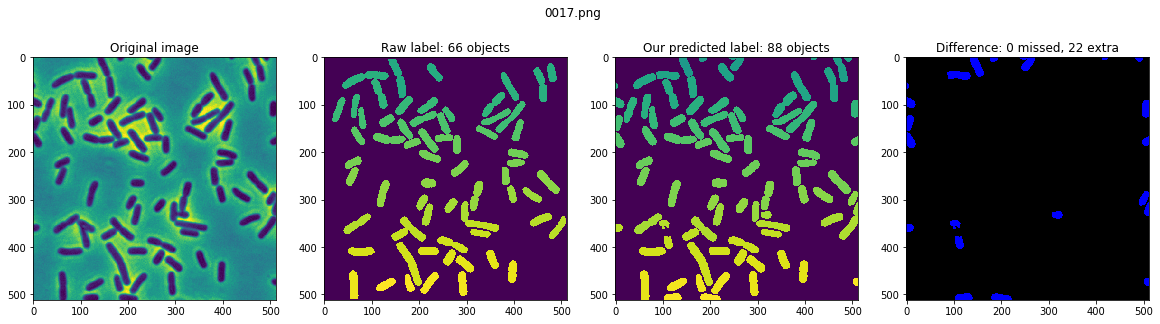

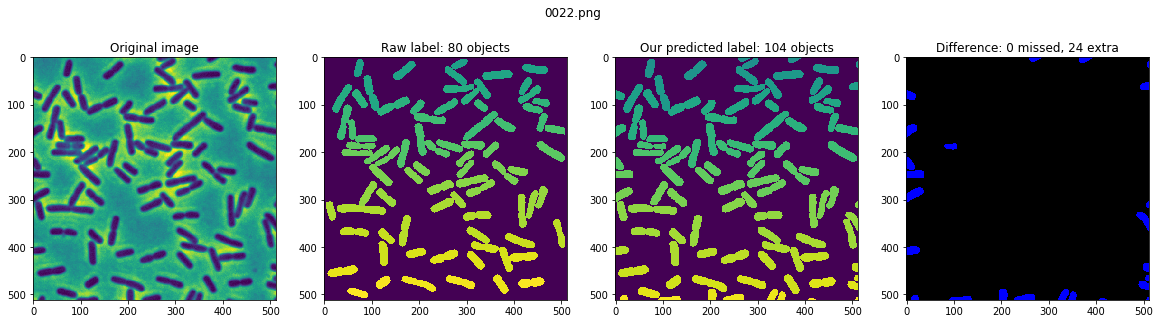

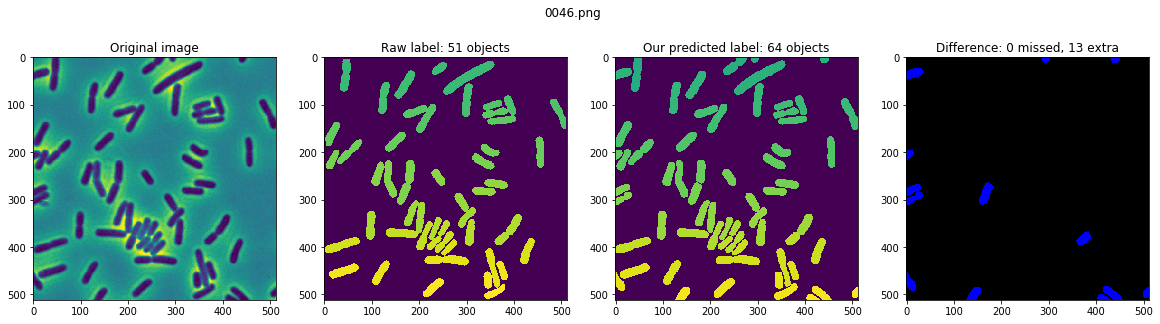

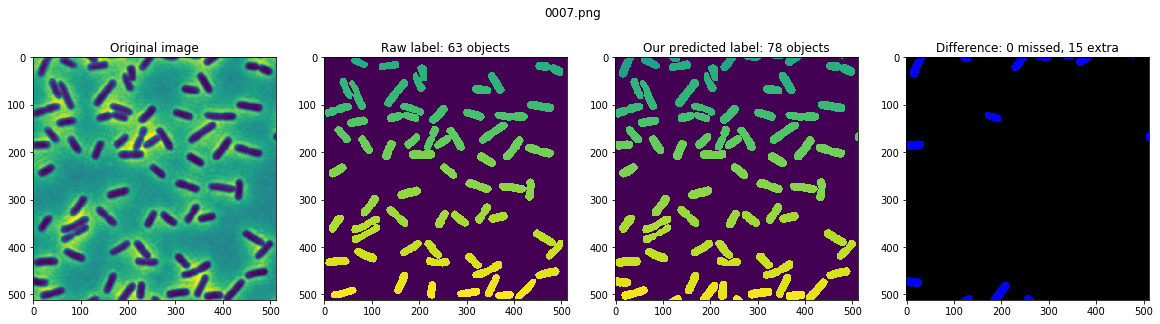

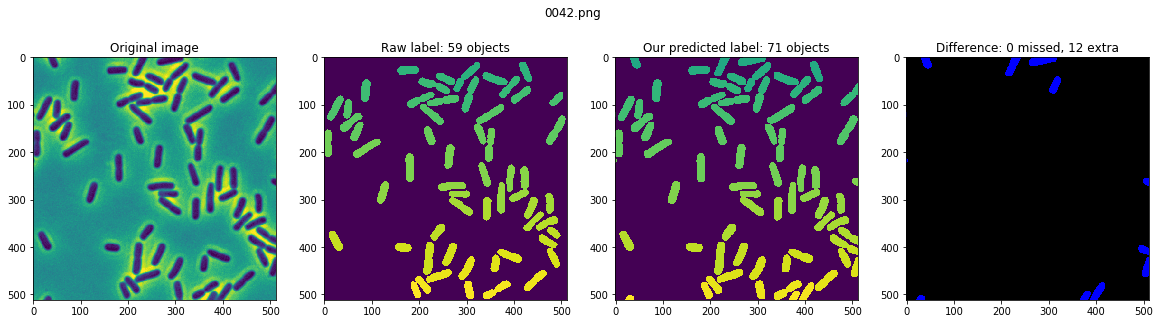

In [41]:
for i in np.random.randint(48, size = 20):
    img = "{:04}".format(i) + ".png"
    compare(img)

### Report of results

In [13]:
results

Image  Threshold        F1   Jaccard  TP  FP  FN
0    0000.png       0.50  0.918033  0.801634  56  10   0
1    0000.png       0.55  0.918033  0.801634  56  10   0
2    0000.png       0.60  0.918033  0.801634  56  10   0
3    0000.png       0.65  0.901639  0.801634  55  11   1
4    0000.png       0.70  0.901639  0.801634  55  11   1
5    0000.png       0.75  0.901639  0.801634  55  11   1
6    0000.png       0.80  0.901639  0.801634  55  11   1
7    0000.png       0.85  0.885246  0.801634  54  12   2
8    0000.png       0.90  0.803279  0.801634  49  17   7
9    0000.png       0.95  0.459016  0.801634  28  38  28
10   0001.png       0.50  0.936508  0.860197  59   7   1
11   0001.png       0.55  0.920635  0.860197  58   8   2
12   0001.png       0.60  0.920635  0.860197  58   8   2
13   0001.png       0.65  0.904762  0.860197  57   9   3
14   0001.png       0.70  0.904762  0.860197  57   9   3
15   0001.png       0.75  0.904762  0.860197  57   9   3
16   0001.png       0.80  0.888889  0.860197  56  10   4
17   0001.png       0.85  0.873016  0.860197  55  11   5
18   0001.png       0.90  0.841270  0.860197  53  13   7
19   0001.png       0.95  0.476190  0.860197  30  36  30
20   0002.png       0.50  0.900585  0.768961  77  17   0
21   0002.png       0.55  0.900585  0.768961  77  17   0
22   0002.png       0.60  0.900585  0.768961  77  17   0
23   0002.png       0.65  0.900585  0.768961  77  17   0
24   0002.png       0.70  0.900585  0.768961  77  17   0
25   0002.png       0.75  0.900585  0.768961  77  17   0
26   0002.png       0.80  0.888889  0.768961  76  18   1
27   0002.png       0.85  0.853801  0.768961  73  21   4
28   0002.png       0.90  0.818713  0.768961  70  24   7
29   0002.png       0.95  0.350877  0.768961  30  64  47
..        ...        ...       ...       ...  ..  ..  ..
450  0045.png       0.50  0.876190  0.739165  46  13   0
451  0045.png       0.55  0.838095  0.739165  44  15   2
452  0045.png       0.60  0.838095  0.739165  44  15   2
453  0045.png       0.65  0.838095  0.739165  44  15   2
454  0045.png       0.70  0.838095  0.739165  44  15   2
455  0045.png       0.75  0.838095  0.739165  44  15   2
456  0045.png       0.80  0.838095  0.739165  44  15   2
457  0045.png       0.85  0.838095  0.739165  44  15   2
458  0045.png       0.90  0.800000  0.739165  42  17   4
459  0045.png       0.95  0.400000  0.739165  21  38  25
460  0046.png       0.50  0.884956  0.735724  50  13   0
461  0046.png       0.55  0.867257  0.735724  49  14   1
462  0046.png       0.60  0.831858  0.735724  47  16   3
463  0046.png       0.65  0.831858  0.735724  47  16   3
464  0046.png       0.70  0.831858  0.735724  47  16   3
465  0046.png       0.75  0.831858  0.735724  47  16   3
466  0046.png       0.80  0.814159  0.735724  46  17   4
467  0046.png       0.85  0.743363  0.735724  42  21   8
468  0046.png       0.90  0.690265  0.735724  39  24  11
469  0046.png       0.95  0.407080  0.735724  23  40  27
470  0047.png       0.50  0.794326  0.676448  56  26   3
471  0047.png       0.55  0.751773  0.676448  53  29   6
472  0047.png       0.60  0.751773  0.676448  53  29   6
473  0047.png       0.65  0.737589  0.676448  52  30   7
474  0047.png       0.70  0.737589  0.676448  52  30   7
475  0047.png       0.75  0.737589  0.676448  52  30   7
476  0047.png       0.80  0.737589  0.676448  52  30   7
477  0047.png       0.85  0.709220  0.676448  50  32   9
478  0047.png       0.90  0.652482  0.676448  46  36  13
479  0047.png       0.95  0.354610  0.676448  25  57  34

[480 rows x 7 columns]

In [8]:
average_performance = results.groupby(["Image", "Threshold"])
average_performance.first()

F1  Precision    Recall   Jaccard  TP  FP  FN
Image    Threshold                                                     
0000.png 0.50       0.918033   0.848485  1.000000  0.801634  56  10   0
         0.55       0.918033   0.848485  1.000000  0.801634  56  10   0
         0.60       0.918033   0.848485  1.000000  0.801634  56  10   0
         0.65       0.901639   0.833333  0.982143  0.801634  55  11   1
         0.70       0.901639   0.833333  0.982143  0.801634  55  11   1
         0.75       0.901639   0.833333  0.982143  0.801634  55  11   1
         0.80       0.901639   0.833333  0.982143  0.801634  55  11   1
         0.85       0.885246   0.818182  0.964286  0.801634  54  12   2
         0.90       0.803279   0.742424  0.875000  0.801634  49  17   7
         0.95       0.459016   0.424242  0.500000  0.801634  28  38  28
0001.png 0.50       0.936508   0.893939  0.983333  0.860197  59   7   1
         0.55       0.920635   0.878788  0.966667  0.860197  58   8   2
         0.60       0.920635   0.878788  0.966667  0.860197  58   8   2
         0.65       0.904762   0.863636  0.950000  0.860197  57   9   3
         0.70       0.904762   0.863636  0.950000  0.860197  57   9   3
         0.75       0.904762   0.863636  0.950000  0.860197  57   9   3
         0.80       0.888889   0.848485  0.933333  0.860197  56  10   4
         0.85       0.873016   0.833333  0.916667  0.860197  55  11   5
         0.90       0.841270   0.803030  0.883333  0.860197  53  13   7
         0.95       0.476190   0.454545  0.500000  0.860197  30  36  30
0002.png 0.50       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.55       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.60       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.65       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.70       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.75       0.900585   0.819149  1.000000  0.768961  77  17   0
         0.80       0.888889   0.808511  0.987013  0.768961  76  18   1
         0.85       0.853801   0.776596  0.948052  0.768961  73  21   4
         0.90       0.818713   0.744681  0.909091  0.768961  70  24   7
         0.95       0.350877   0.319149  0.389610  0.768961  30  64  47
...                      ...        ...       ...       ...  ..  ..  ..
0045.png 0.50       0.876190   0.779661  1.000000  0.739165  46  13   0
         0.55       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.60       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.65       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.70       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.75       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.80       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.85       0.838095   0.745763  0.956522  0.739165  44  15   2
         0.90       0.800000   0.711864  0.913043  0.739165  42  17   4
         0.95       0.400000   0.355932  0.456522  0.739165  21  38  25
0046.png 0.50       0.884956   0.793651  1.000000  0.735724  50  13   0
         0.55       0.867257   0.777778  0.980000  0.735724  49  14   1
         0.60       0.831858   0.746032  0.940000  0.735724  47  16   3
         0.65       0.831858   0.746032  0.940000  0.735724  47  16   3
         0.70       0.831858   0.746032  0.940000  0.735724  47  16   3
         0.75       0.831858   0.746032  0.940000  0.735724  47  16   3
         0.80       0.814159   0.730159  0.920000  0.735724  46  17   4
         0.85       0.743363   0.666667  0.840000  0.735724  42  21   8
         0.90       0.690265   0.619048  0.780000  0.735724  39  24  11
         0.95       0.407080   0.365079  0.460000  0.735724  23  40  27
0047.png 0.50       0.794326   0.682927  0.949153  0.676448  56  26   3
         0.55       0.751773   0.646341  0.898305  0.676448  53  29   6
         0.60       0.751773   0.646341  0.898305  0.676448  53  2

In [9]:
average_performance = results.groupby(["Threshold"]).mean()
average_performance

F1  Precision    Recall   Jaccard
Threshold                                         
0.50       0.880331   0.794401  0.989667  0.748379
0.55       0.870486   0.785609  0.978460  0.748379
0.60       0.866145   0.781699  0.973571  0.748379
0.65       0.864357   0.780103  0.971527  0.748379
0.70       0.861972   0.777968  0.968823  0.748379
0.75       0.858966   0.775247  0.965454  0.748379
0.80       0.848584   0.765861  0.953817  0.748379
0.85       0.796755   0.719426  0.895053  0.748379
0.90       0.748593   0.676003  0.840849  0.748379
0.95       0.380172   0.343249  0.427144  0.748379

In [67]:
# Display accuracy results
# 在以相同Threshold为一组中取另外columns的平均值，为什么那三列没有了？

average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

Threshold        F1   Jaccard
0       0.50  0.880331  0.748379
1       0.55  0.870486  0.748379
2       0.60  0.866145  0.748379
3       0.65  0.864357  0.748379
4       0.70  0.861972  0.748379
5       0.75  0.858966  0.748379
6       0.80  0.848584  0.748379
7       0.85  0.796755  0.748379
8       0.90  0.748593  0.748379
9       0.95  0.380172  0.748379

In [69]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1",ascending=False).loc[12, "Image"]  
# R

'0012.png'

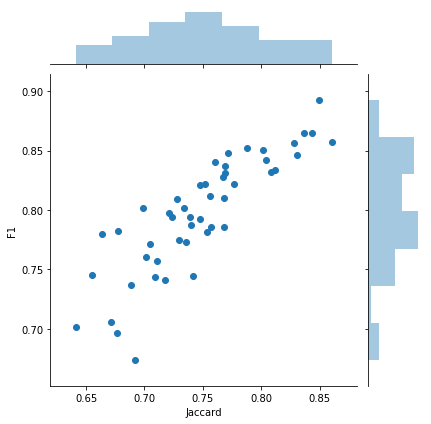

In [70]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

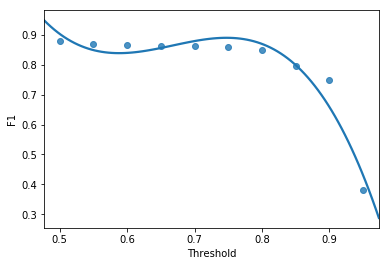

In [71]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [72]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.7976362157346384
Jaccard index: 0.7483787586141927


In [74]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei       NaN
Small nuclei     26.0
Normal nuclei    14.0
Large nuclei     57.0
Name: False_Negative, dtype: float64

In [75]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 66
Merges: 5


In [76]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 910
